In [1]:
#%conda install spectrum

In [2]:
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import util
from scipy.fft import fft, ifft, fftfreq, rfft
import pickle
from obspy import UTCDateTime
import scipy.signal as signal
from spectrum import *
from pylab import *

In [3]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'

In [4]:
eq_list = os.listdir(root)

client = Client("IRIS")

cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml')

eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])

do_ypcall: clnt_call: RPC: Timed out
do_ypcall: clnt_call: RPC: Timed out
do_ypcall: clnt_call: RPC: Timed out


In [5]:
binned_spectra = [
    [[],[],[],[]], #0
    [[],[],[],[]], #1
    [[],[],[],[]], #2
    [[],[],[],[]], #3
    [[],[],[],[]], #4
    [[],[],[],[]], #5
    [[],[],[],[]], #6
    [[],[],[],[]], #7
    [[],[],[],[]] #8
]

CX.HMBCX.


(0.5, 50)

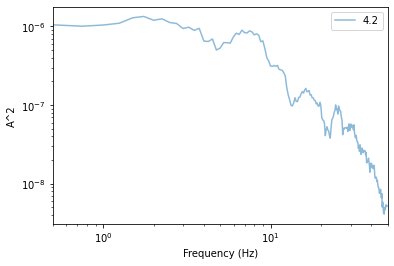

In [6]:
cmap = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
fig, axs = plt.subplots(1,1)
failed = []
for eq_no in range(0, len(eq_with_data[0:1])):
    eq_name = eq_with_data[eq_no]
    try:
        data = obspy.read(root+eq_name+'/data/*/*')
        #data.plot()
        inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
        data.remove_response(inv)
        with open(root+eq_name+'/picks.pkl', 'rb') as f:
            picks = pickle.load(f)
    except: 
        break
    if len(data)>0:
        successful = 0
        for tr_no in range(0, 1): #len(data)):
            good = True
            try:
                sr = data[tr_no].stats.sampling_rate
                tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
                print(tr_name)
                pick = UTCDateTime(picks[tr_name])
                start = pick #int((pick - data[tr_no].stats.starttime)*sr)
                end = pick + 4 # int(start + 4 * sr)
                d = data[tr_no].copy()#.filter('lowpass', freq=10)
                d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
                d.detrend()
                d.integrate()
                d.detrend()
                coda = d.trim(start, end)
                coda.detrend()
                ave = np.average(coda.data)
                if ave >= 10**(-7):
                    good = False
                if good==True:
                    dt = d.stats.delta

                    #creating the frequencies to plot on x axis 
                    Pfreq  = scipy.fft.rfftfreq(len(coda),dt)

                    #doing the multitaper to get the spectra 
                    N = len(coda)
                    NW=0.01*N
                    k=25
                    [tapers, eigen] = dpss(N, NW, k)
                    for eigen_no in range(0, len(eigen)):
                        if eigen[eigen_no] <= 0.5:
                            k = eigen_no
                            break
                    [tapers, eigen] = dpss(N, NW, k)

                    #print(eigen)
                    freq_complex, weights, eigenvalues=pmtm(coda, e=eigen, v=tapers, show=False)
                    freq = abs(freq_complex)
                    freq = np.mean(freq,axis =0)
                    freq_sdv = np.std(freq,axis =0)

                    dist = util.calc_hypo_dist(cat_with_data[eq_no], d, inv)
                    mag = cat_with_data[eq_no].magnitudes[0].mag
                    binned_spectra[int(np.round(mag, 0))][int(dist//50)].append([Pfreq[:-1],freq[0:N//2]])

                    #plotting the spectra in loglog
                    #print('plot')
                    if successful == 0:
                        axs.plot(Pfreq[:-1],freq[0:N//2], alpha = 0.5, label=str(cat_with_data[eq_no].magnitudes[0].mag), color = cmap[eq_no])#tr_name + data[tr_no].stats.channel)
                    #plt.fill_between(Pfreq[:-1],(Sk+Sk_sdv)[0:N//2],(Sk-Sk_sdv)[0:N//2],alpha=0.2)
                    #-min(freq[0:N//2])
                        axs.set_xlabel('Frequency (Hz)');
                        axs.set_ylabel('A^2');
                    #plt.title(tr_name + data[tr_no].stats.channel+' coda wave Power spectra');
                    else:
                        axs.plot(Pfreq[:-1],freq[0:N//2], color = cmap[eq_no], alpha = 0.5)#tr_name + data[tr_no].stats.channel)

                    Pfreq_MHZ = Pfreq
                    freq_MHZ = freq 
                    successful += 1
                else:
                    failed.append([eq_name, tr_name])
                #print(freq_MHZ.shape)
                #plt.show()
            except:
                failed.append([eq_name, tr_name])
axs.legend();
#axs.set_title('M'+str(cat_with_data[eq_no].magnitudes[0].mag) + ' ' + eq_name)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlim(0.5, 50)
#plt.close()


/tmp/ipykernel_2192705/1713907047.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (a, b) = np.array(binned_spectra).shape
/tmp/ipykernel_2192705/1713907047.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim([0, 50])


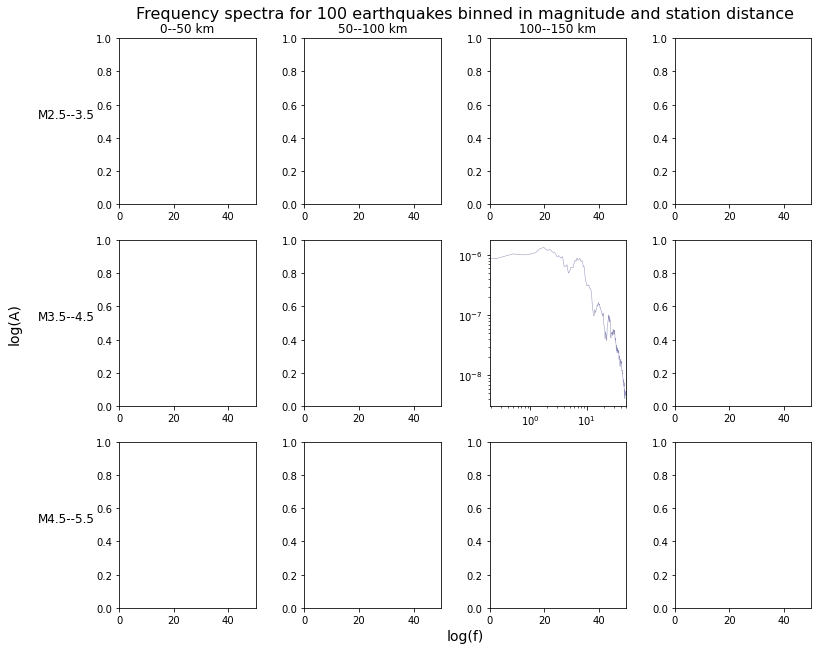

In [7]:
import random
(a, b) = np.array(binned_spectra).shape
fig, axs = plt.subplots(3, b, figsize=(12.8,9.6))
for mag_no in range(3, 6): #len(binned_spectra)):
    for dist_no in range(len(binned_spectra[mag_no])):
        for item in binned_spectra[mag_no][dist_no]:
            axs[mag_no-3][dist_no].plot(item[0], item[1], color = 'midnightblue', alpha = random.randrange(10,70,1)/100, linewidth = 0.5)
            axs[mag_no-3][dist_no].set_yscale('log')
            axs[mag_no-3][dist_no].set_xscale('log')
#axs[3][0].set_xticks([])
#axs[3][2].set_xticks([])
#axs[3][3].set_xticks([])
#axs[3][0].set_yticks([])
#axs[3][2].set_yticks([])
#axs[3][3].set_yticks([])
for row in axs:
    for ax in row:
        ax.set_xlim([0, 50])
#ax.set_yticks([])
axs[0][0].set_ylabel('M2.5--3.5', rotation=0, labelpad=30, fontsize = 12)
axs[1][0].set_ylabel('M3.5--4.5', rotation=0, labelpad=30, fontsize = 12)
axs[2][0].set_ylabel('M4.5--5.5', rotation=0, labelpad=30, fontsize = 12)
#axs[3][0].set_ylabel('M5.5--6.5', rotation=0, labelpad=55, fontsize = 12)
axs[0][0].set_title('0--50 km')
axs[0][1].set_title('50--100 km')
axs[0][2].set_title('100--150 km')
#axs[0][3].set_title('150--200 km')
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.title('Frequency spectra for 100 earthquakes binned in magnitude and station distance', fontsize = 16, pad = 20)
plt.xlabel("log(f)", fontsize = 14)#, labelpad=50)
plt.ylabel("log(A)", fontsize = 14, labelpad=75)
fig.tight_layout()
#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/spectra/3000_eq')


In [8]:
inv

Inventory created at 2021-10-28T15:56:51.413805Z
	Sending institution: SeisComP (GFZ)
	Contains:
		Networks (3):
			CX (3x)
		Stations (3):
			CX.HMBCX (IPOC Station Humberstone, Chile)
			CX.PB01 (IPOC Station Huatacondo, Chile)
			CX.PB08 (IPOC Station Macaya, Chile)
		Channels (9):
			CX.HMBCX..HHZ, CX.HMBCX..HHN, CX.HMBCX..HHE, CX.PB01..HHZ, 
			CX.PB01..HHN, CX.PB01..HHE, CX.PB08..HHZ, CX.PB08..HHN, 
			CX.PB08..HHE

In [9]:
axs.set_xlim(0.01, 52)
axs.set_ylim(0.00000001, 10)
plt.show()
fig

AttributeError: 'numpy.ndarray' object has no attribute 'set_xlim'

In [ ]:
np.round(3.4, 0)